<a href="https://colab.research.google.com/github/Saikattanu/JU-practice/blob/main/LULC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [1]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Google Colab GPU

In [2]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


## Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="data-description"></a>
# Data Description

- Download the EuroSAT dataset into Google Drive
- Generate the train and test sets by splitting the EuroSAT dataset
- Visualize a sample of the images and their LULC labels

## EuroSAT Dataset
The [EuroSAT dataset](https://github.com/phelber/EuroSAT) contains 27,000 labelled 64x64 pixel Sentinel-2 satellite image patches with 10 different LULC categories. I am using RGB image for this task.

In [5]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2024-06-25 16:41:05--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  13.3MB/s    in 8.1s    

2024-06-25 16:41:14 (11.1 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



## Generate Train and Test Sets

### Create Custom Dataset Class


In [10]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

### Data Augmentation & Image Normalization

In [11]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### Load EuroSAT Dataset


In [12]:
# Load the dataset
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


### Split into Train, Validation, and Test Sets
The dataset is split here into a train set and a test set. It is arranged that 70% of the Eurosat dataset, selected randomly, constitutes the training set. Additionally, 15% of the dataset is set aside as the validation set, and the remaining 15% is reserved as the test set.

In [13]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
val_data = EuroSAT(dataset, val_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 70% train / 15% val / 15% test
# by subsetting the transformed train and test datasets
train_size = 0.70
val_size = 0.15
indices = list(range(int(len(dataset))))
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(test_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 18900/4050/4050


Finally, the DataLoader class from torch is used to create a dataloader. This dataloader is responsible for managing the fetching of samples from the datasets, which it can accomplish in parallel using num_workers. Additionally, it assembles batches of the datasets.

In [14]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = data.DataLoader(
    val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

## Visualize Data

In the cell below, visualizing a batch of the dataset.  The cell visualizes the input to the neural network (the RGB image) along with the associated label.

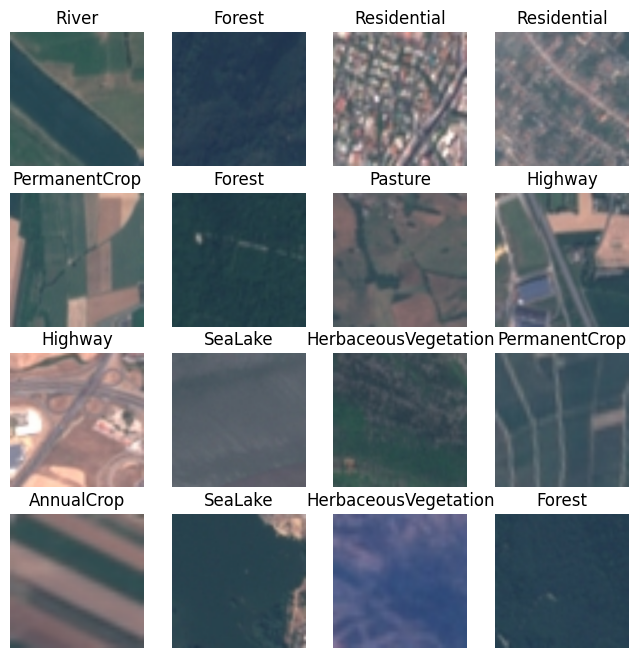

In [15]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

# Exploratory Data Analysis

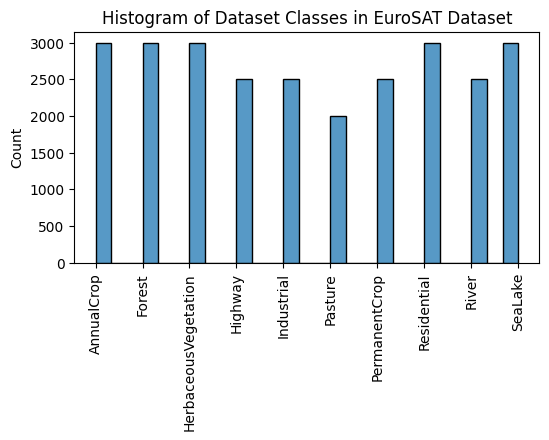

In [16]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

# Model Development

## Instantiate Model: ResNet-50

In [17]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model Training and Evaluation

This section has three major parts:

1. Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2. Train the model on the training set by updating its weights to minimize the loss function.
3. Evaluate the model on the test set to observe performance on new, unseen data.
4. Repeat steps 2 and 3 `n_epochs` times.

In [18]:
# Specify number of epochs and learning rate
n_epochs = 10
lr = 1e-3

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

Create training function.

In [19]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

Next, let's define the model evaluation function.

In [20]:
def evaluate(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

Putting it all together, we define the `fit` function for training and evaluating the model on the training set and validation set, respectively.

In [21]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  # Keep track of the best loss and
  # best model weights with the lowest loss
  best_loss = np.inf
  best_model = None

  # Train and test over n_epochs
  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

Model training and evaluation can now be commenced in the following cell.

In [23]:
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.71; Accuracy: 50.21


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.18; Accuracy: 69.68
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.94; Accuracy: 72.17


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.69; Accuracy: 82.00
Epoch 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.70; Accuracy: 77.71


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.53; Accuracy: 84.57
Epoch 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.58; Accuracy: 81.00


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.36; Accuracy: 90.54
Epoch 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.51; Accuracy: 83.46


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.33; Accuracy: 90.12
Epoch 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.46; Accuracy: 84.84


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.24; Accuracy: 93.51
Epoch 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.42; Accuracy: 86.14


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.20; Accuracy: 94.69
Epoch 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.39; Accuracy: 87.17


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.18; Accuracy: 95.09
Epoch 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.39; Accuracy: 87.52


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.17; Accuracy: 95.11
Epoch 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.36; Accuracy: 88.38


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.17; Accuracy: 94.96


In the above, the model was only trained for 10 epochs.

## Model Performance on the Test Set
Using the best model from the previous steps, the model performance can be evaluated on the test set.

In [24]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

  0%|          | 0/254 [00:00<?, ?it/s]

Test Loss: 0.18; Accuracy: 94.52


## Save Model

Define a function for saving the model to local Google drive.


In [26]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

'./drive/My Drive/Colab Notebooks/models/best_model.pth'

In [27]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [28]:
save_model(best_model, model_file)

Model successfully saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth.


## Load Model


In [29]:
def load_model(model_file):
  # Uncomment this to download the model file
  #if not os.path.isfile(model_file):
  #  model_file = 'best_model.pth'
  #  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

  model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
  model.fc = torch.nn.Linear(model.fc.in_features, 10)
  model.load_state_dict(torch.load(model_file))
  model.eval()

  print('Model file {} successfully loaded.'.format(model_file))
  return model

In [30]:
model = load_model(model_file)

Model file ./drive/My Drive/Colab Notebooks/models/best_model.pth successfully loaded.


<a name="results"></a>
# Results

Visualize an example of the neural network making a prediction.

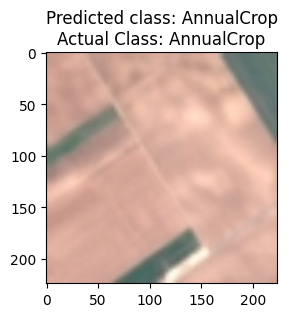

In [31]:
# Retrieve sample image
index = 15
image, label = test_data[index]

# Predict on sample
model = model.to("cpu")
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

Here, we show how to run the model on a PIL image.

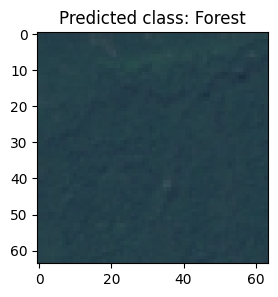

In [32]:
from PIL import Image
image_path = './EuroSAT/2750/Forest/Forest_2.jpg'
image = Image.open(image_path)

# Transform image
input = test_transform(image)

# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));

# Imports and Setup

In [10]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [11]:
# Standard imports
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
# import geemap.eefolium as emap  # Remove this line as eefolium is no longer a submodule
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Authenticate Google Earth Engine

In [13]:
ee.Authenticate()
ee.Initialize(project="mangrove-mapping-427519")

<a name="admin-bounds"></a>
# Download Country Boundaries

In [24]:
ISO = 'BGD' # "BGD" is the ISO code for Bangladesh
ADM = 'ADM3' # Equivalent to administrative districts

# Query geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (544, 6)


shapeName shapeISO                 shapeID shapeGroup shapeType  \
64       Betagi           5055444B49366988279383        BGD      ADM3   
143  Dhamoirhat           5055444B49062995436606        BGD      ADM3   
383   Nawabganj           5055444B29878683718336        BGD      ADM3   

                                              geometry  
64   POLYGON ((90.19049 22.47953, 90.19046 22.47949...  
143  POLYGON ((88.94084 25.04148, 88.94089 25.04157...  
383  POLYGON ((89.09502 25.55044, 89.09509 25.55063...

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('shapeName').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('shapeID').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['shapeID'].value_counts()
    for x_label, grp in _df_12.groupby('shapeName')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('shapeName')
_ = plt.ylabel('shapeID')

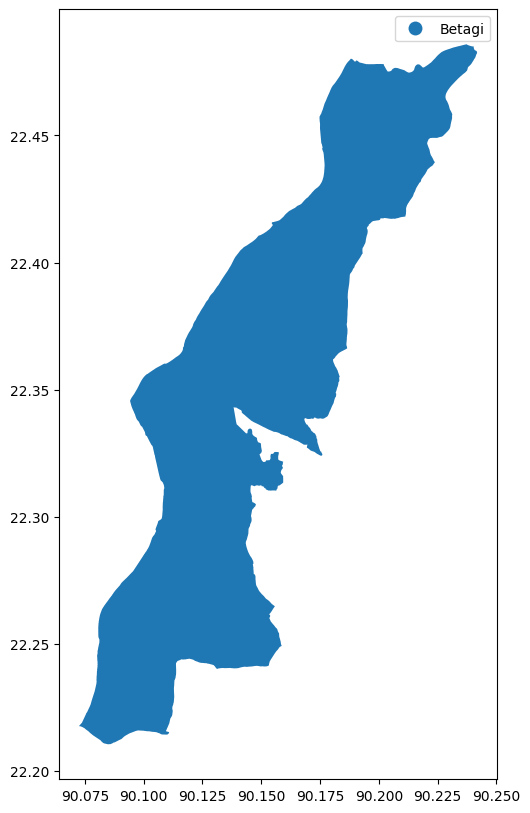

In [25]:
shape_name = 'Betagi'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

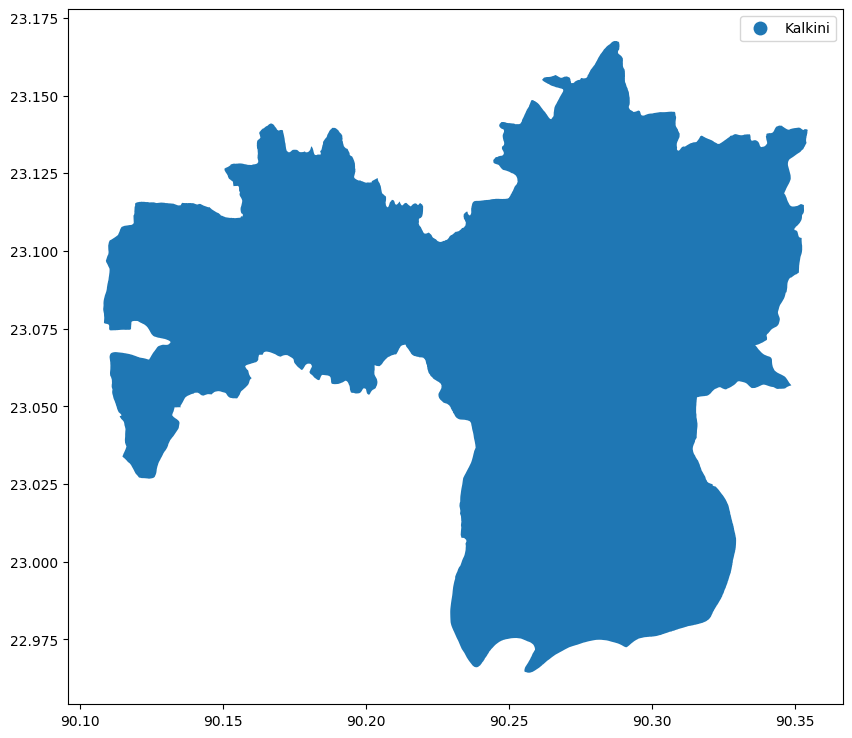

In [26]:
shape_name = 'Kalkini'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

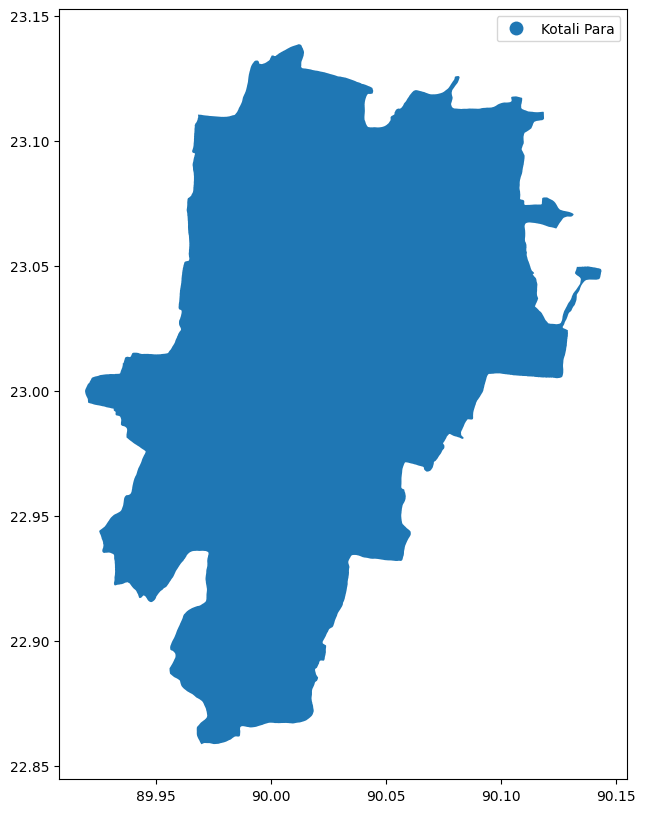

In [29]:
shape_name = 'Kotali Para'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

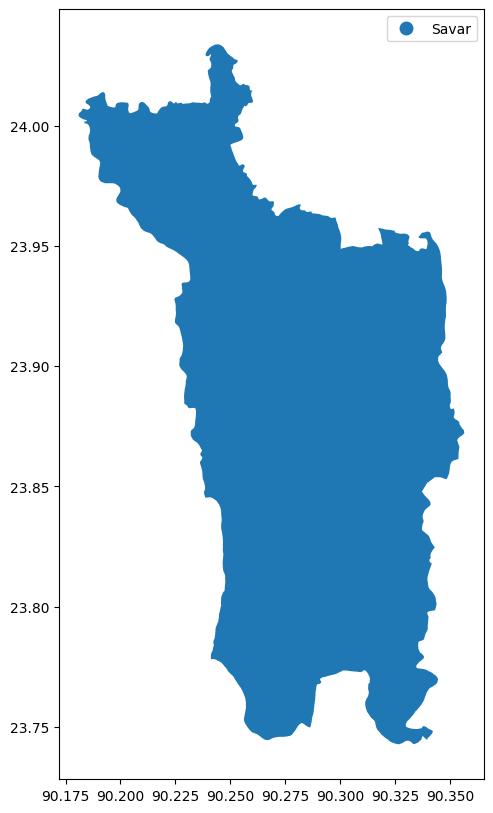

In [30]:
shape_name = 'Savar'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

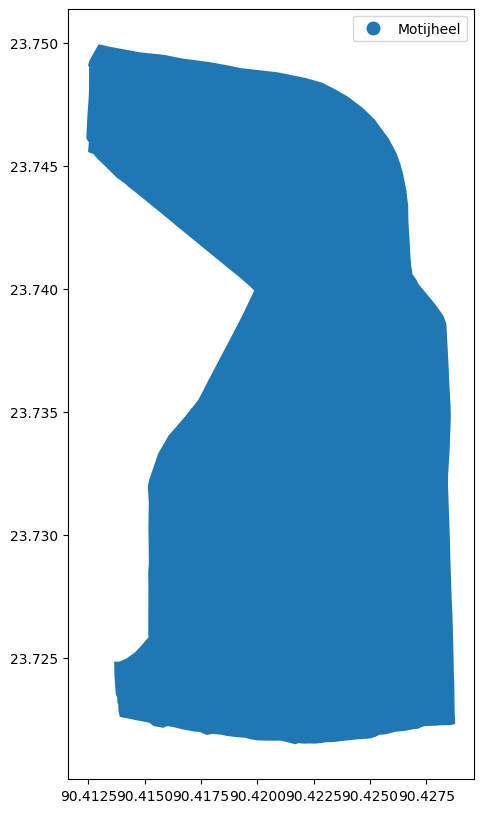

In [32]:
shape_name = 'Motijheel'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

In [14]:
ISO = 'DEU' # "DEU" is the ISO code for Germany
ADM = 'ADM3' # Equivalent to administrative districts

# Query geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (428, 6)


shapeName shapeISO                  shapeID shapeGroup  \
368  Herzogtum Lauenburg           24449704B26583852637810        DEU   
394  Saalfeld-Rudolstadt           24449704B85411198139338        DEU   
51             Ebersberg            24449704B6441605282223        DEU   

    shapeType                                           geometry  
368      ADM3  MULTIPOLYGON (((10.30795 53.43320, 10.30887 53...  
394      ADM3  POLYGON ((11.48157 50.43162, 11.48405 50.43270...  
51       ADM3  POLYGON ((11.84795 47.94825, 11.84784 47.94792...

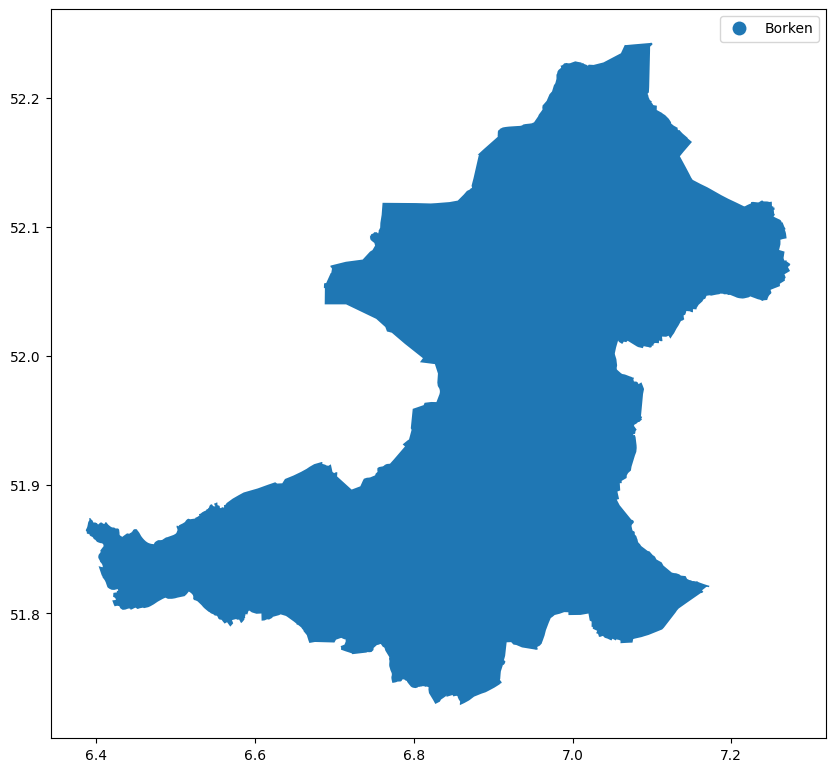

In [15]:
shape_name = 'Borken'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

In [25]:
import geemap

In [26]:
import geemap
Map = geemap.Map(center=[centroid.y, centroid.x], zoom=10)


In [27]:
dir(geemap)  # This will list all available functions and modules within geemap

['Any',
 'Box',
 'Dict',
 'EEFoliumTileLayer',
 'EELeafletTileLayer',
 'IFrame',
 'Image',
 'ImageOverlay',
 'Javascript',
 'List',
 'Map',
 'Node',
 'Optional',
 'Path',
 'PlanetaryComputerEndpoint',
 'Report',
 'TitilerEndpoint',
 'Tree',
 'Tuple',
 'Union',
 '__author__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__email__',
 '__file__',
 '__init__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_use_eerepr',
 'add_crs',
 'add_image_to_gif',
 'add_overlay',
 'add_progress_bar_to_gif',
 'add_text_to_gif',
 'adjust_longitude',
 'annual_NAIP',
 'api_docs',
 'arc_active_map',
 'arc_active_view',
 'arc_add_layer',
 'arc_zoom_to_extent',
 'array_mean',
 'array_sum',
 'array_to_image',
 'array_to_memory_file',
 'bands_to_image_collection',
 'bar_chart',
 'basemaps',
 'bbox_coords',
 'bbox_to_gdf',
 'bbox_to_geojson',
 'blend',
 'bounds_to_xy_range',
 'box',
 'build_api_tree',
 'build_asset_tree',
 'build_repo_tree',
 'builtin_legends',
 'center

In [28]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

In [30]:
import geemap

# Get the shape geometry for Kreis Borken
region = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region)  # Convert geodataframe to feature collection

# Define a function to generate an image using GEE
def generate_image(region, product, min_date, max_date, cloud_pct):
    collection = ee.ImageCollection(product) \
                    .filterBounds(region) \
                    .filterDate(min_date, max_date) \
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_pct))
    return collection.median()  # Using median to reduce image collection to a single image

# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2',  # Sentinel-2 data
    min_date='2021-01-01',
    max_date='2021-12-31',
    cloud_pct=10
)

# Visualize map
Map = geemap.Map(center=[centroid[1], centroid[0]], zoom=10)  # Adjusting order of coordinates for latitude and longitude
Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 RGB')
Map.addLayerControl()  # Add layer controls to the map
Map  # Display the map


Map(center=[51.96133020233346, 6.899640599562037], controls=(WidgetControl(options=['position', 'transparent_b…

In [31]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

In [33]:
folder = 'Colab Notebooks'
task = export_image(image, shape_name, region, folder)

Exporting to Borken.tif ...


In [34]:
{'state': 'RUNNING',
 'description': 'Borken',
 'priority': 100,
 'creation_timestamp_ms': 1717227827019,
 'update_timestamp_ms': 1717227830338,
 'start_timestamp_ms': 1717227830263,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'W3JEHOJXBXEQM7DAXZPDRT5R',
 'name': 'projects/mangrove-mapping/operations/W3JEHOJXBXEQM7DAXZPDRT5R'}

{'state': 'RUNNING',
 'description': 'Borken',
 'priority': 100,
 'creation_timestamp_ms': 1717227827019,
 'update_timestamp_ms': 1717227830338,
 'start_timestamp_ms': 1717227830263,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'W3JEHOJXBXEQM7DAXZPDRT5R',
 'name': 'projects/mangrove-mapping/operations/W3JEHOJXBXEQM7DAXZPDRT5R'}

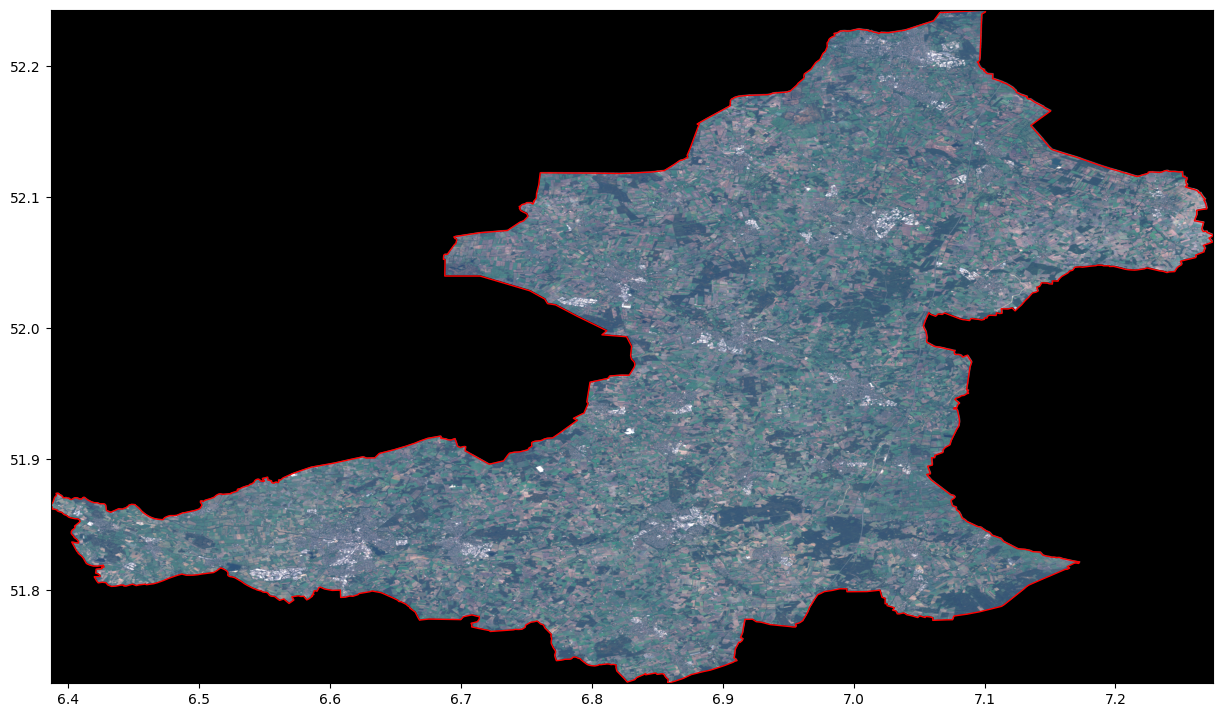

In [36]:
import  os

# Change this to your image file path
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = os.path.join(cwd, '{}.tif'.format(shape_name))

# Uncomment this to download the TIF file
if not os.path.isfile(tif_file):
  tif_file = '{}.tif'.format(shape_name)
  !gdown "12VJQBht4n544OXh4dmugqMESXXxRlBcU"

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

In [37]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

In [38]:
output_file = os.path.join(cwd, '{}.geojson'.format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

# Uncomment this to download GeoJSON file
#if not os.path.isfile(output_file):
#  output_file = '{}.geojson'.format(shape_name)
#  !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/56585900 [00:00<?, ?it/s]

Data dimensions: (13950, 2)


id                                           geometry
0  borken-0  POLYGON ((6.39241 52.23739, 6.39241 52.24314, ...
1  borken-1  POLYGON ((6.39816 52.23739, 6.39816 52.24314, ...
2  borken-2  POLYGON ((6.40391 52.23739, 6.40391 52.24314, ...

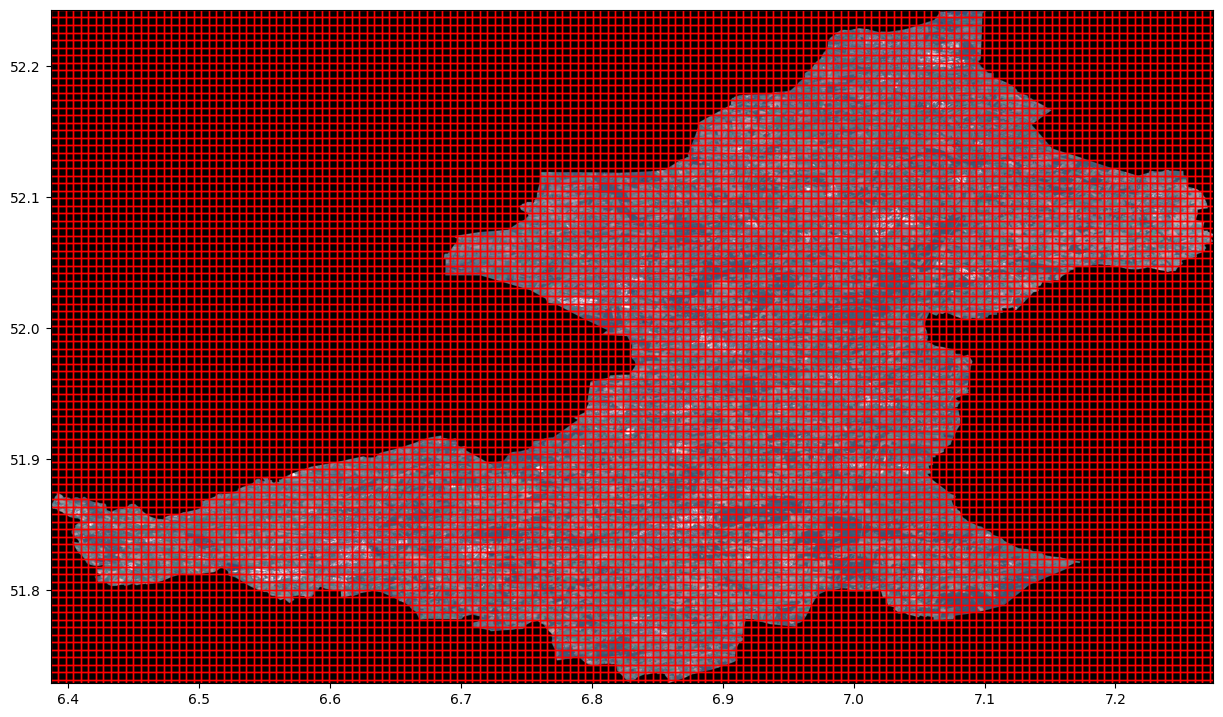

In [39]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

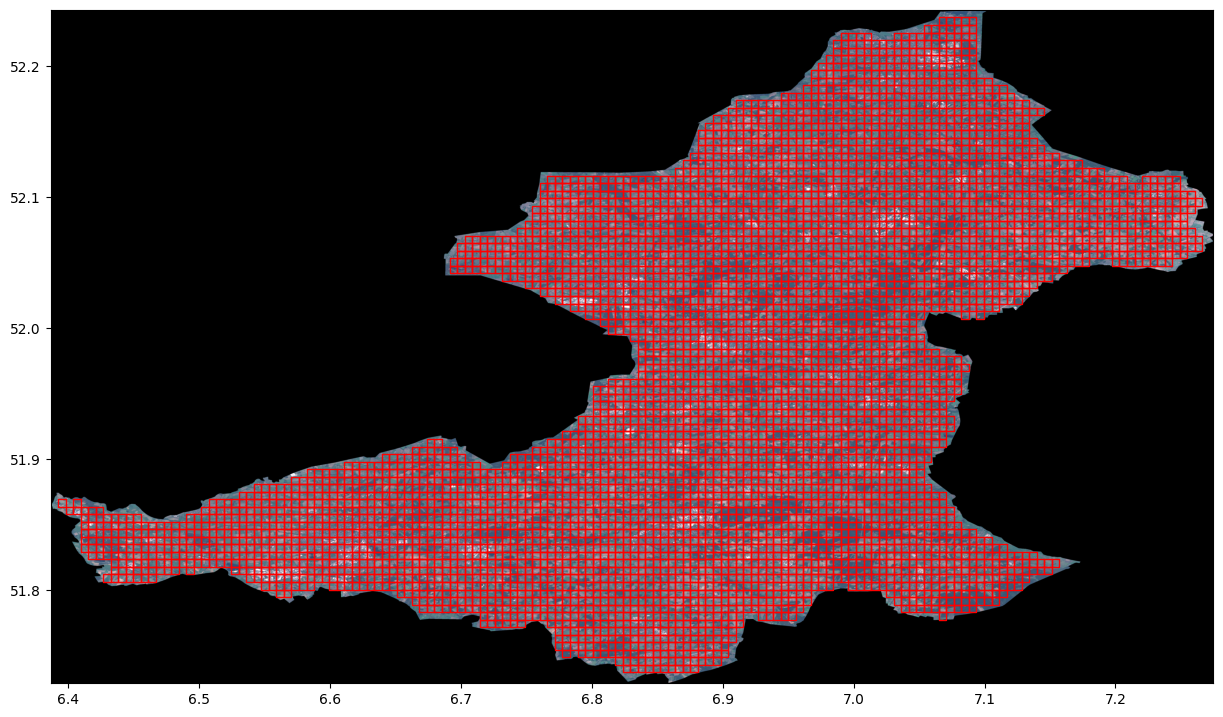

In [40]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

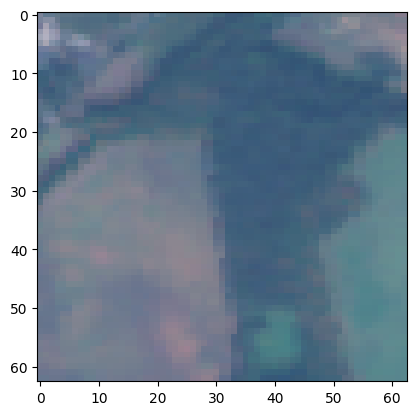

In [41]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

In [42]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'/models/best_model.pth'

# Uncomment this to download the model file
if not os.path.isfile(model_file):
  model_file = 'best_model.pth'
  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file ./drive/My Drive/Colab Notebooks//models/best_model.pth successfully loaded.


In [45]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [46]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

In [ ]:
# Commence model prediction
labels = [] # Store predictions
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Save predictions
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/5294 [00:00<?, ?it/s]